In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline


In [60]:
base_data = pd.read_csv("nyc_housing_base.csv")

In [61]:
# Clean data
cleaned_data = base_data.drop_duplicates()
cleaned_data = base_data.drop("borough_x", axis=1)

# Extract building class letter
cleaned_data["bldg_class_letter"] = cleaned_data["bldgclass"].str[0]

In [62]:
zip_codes = cleaned_data["zip_code"].drop_duplicates().dropna().values
zc_comdens = []
zc_avg_ppa = []
zc_majority_bldg_class = []

for zc in zip_codes:
    # Get commercial density per zip code region
    zc_data = cleaned_data.query(f"zip_code == {zc}")
    tot_comarea = zc_data["comarea"].sum()
    tot_bldgarea = zc_data["bldgarea"].sum()
    zc_comdens.append(tot_comarea / tot_bldgarea)

    # Get average price per area per zip code region
    res_data = zc_data.query("resarea > 0 and comarea == 0")
    ppa_data = res_data["sale_price"] / res_data["bldgarea"]
    zc_avg_ppa.append(ppa_data.mean())
    
    # Find majority building class letter in this zip code
    majority_class = zc_data["bldg_class_letter"].value_counts().idxmax()
    zc_majority_bldg_class.append(majority_class)

A+B data points: 97
A+B polynomial plotted successfully
C+D data points: 77
C+D polynomial plotted successfully


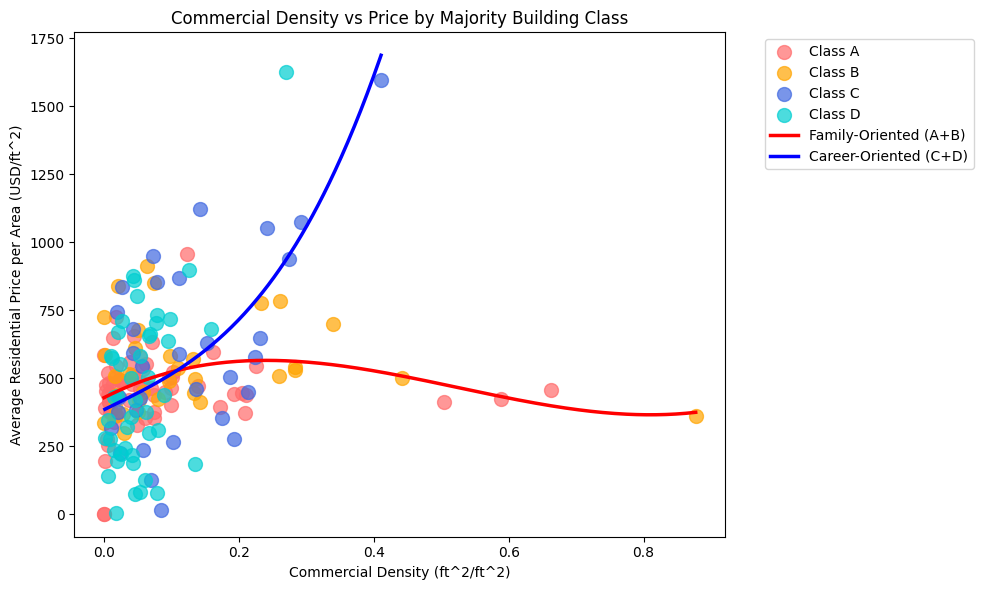

In [64]:
# Create scatter plot colored by majority building class
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique building classes and assign colors
unique_classes = sorted(set(zc_majority_bldg_class))
# Remove Class O and Class S
unique_classes = [cls for cls in unique_classes if cls not in ['O', 'S']]

# Create custom color map: warm colors for A, B and cool colors for C, D
color_map = {}
warm_colors = ['#FF6B6B', '#FFA500']  # Red and Orange for A, B
cool_colors = ['#4169E1', '#00CED1']  # Royal Blue and Dark Turquoise for C, D
other_colors = plt.cm.Set3(np.linspace(0, 1, max(0, len(unique_classes) - 4)))

color_idx = 0
for cls in sorted(unique_classes):
    if cls == 'A':
        color_map[cls] = warm_colors[0]
    elif cls == 'B':
        color_map[cls] = warm_colors[1]
    elif cls == 'C':
        color_map[cls] = cool_colors[0]
    elif cls == 'D':
        color_map[cls] = cool_colors[1]
    else:
        color_map[cls] = other_colors[color_idx % len(other_colors)]
        color_idx += 1

# Plot each point colored by its majority building class
for cls in unique_classes:
    mask = np.array(zc_majority_bldg_class) == cls
    ax.scatter(np.array(zc_comdens)[mask], np.array(zc_avg_ppa)[mask], 
               label=f"Class {cls}", color=color_map[cls], alpha=0.7, s=100)

# Fit polynomials to A+B (Family-Oriented) and C+D (Career-Oriented)
comdens_arr = np.array(zc_comdens)
ppa_arr = np.array(zc_avg_ppa)
bldg_class_arr = np.array(zc_majority_bldg_class)

# Family-Oriented: Classes A and B
ab_mask = np.isin(bldg_class_arr, ['A', 'B'])
ab_mask = ab_mask & ~np.isnan(comdens_arr) & ~np.isnan(ppa_arr)  # Filter NaN values
print(f"A+B data points: {ab_mask.sum()}")
if ab_mask.sum() > 2:  # Need at least 3 points for polynomial
    ab_comdens = comdens_arr[ab_mask]
    ab_ppa = ppa_arr[ab_mask]
    try:
        # Fit 3rd degree polynomial
        ab_coeffs = np.polyfit(ab_comdens, ab_ppa, 3)
        ab_poly = np.poly1d(ab_coeffs)
        ab_x = np.linspace(ab_comdens.min(), ab_comdens.max(), 300)
        ax.plot(ab_x, ab_poly(ab_x), 'r-', linewidth=2.5, label='Family-Oriented (A+B)', zorder=10)
        print("A+B polynomial plotted successfully")
    except Exception as e:
        print(f"Error fitting A+B polynomial: {e}")
else:
    print(f"Not enough A+B points for polynomial (need 3, have {ab_mask.sum()})")

# Career-Oriented: Classes C and D
cd_mask = np.isin(bldg_class_arr, ['C', 'D'])
cd_mask = cd_mask & ~np.isnan(comdens_arr) & ~np.isnan(ppa_arr)  # Filter NaN values
print(f"C+D data points: {cd_mask.sum()}")
if cd_mask.sum() > 2:  # Need at least 3 points for polynomial
    cd_comdens = comdens_arr[cd_mask]
    cd_ppa = ppa_arr[cd_mask]
    try:
        # Fit 3rd degree polynomial
        cd_coeffs = np.polyfit(cd_comdens, cd_ppa, 3)
        cd_poly = np.poly1d(cd_coeffs)
        cd_x = np.linspace(cd_comdens.min(), cd_comdens.max(), 300)
        ax.plot(cd_x, cd_poly(cd_x), 'b-', linewidth=2.5, label='Career-Oriented (C+D)', zorder=10)
        print("C+D polynomial plotted successfully")
    except Exception as e:
        print(f"Error fitting C+D polynomial: {e}")
else:
    print(f"Not enough C+D points for polynomial (need 3, have {cd_mask.sum()})")

ax.set_xlabel("Commercial Density (ft^2/ft^2)")
ax.set_ylabel("Average Residential Price per Area (USD/ft^2)")
ax.set_title("Commercial Density vs Price by Majority Building Class")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()